# Project 3:  Implement SLAM 

---

## Project Overview

In this project, I implement SLAM for a robot that moves and senses in a 2 dimensional, grid world.

SLAM (Simultaneous Location and Mapping) provides a way to both localize a robot and build up a map of its environment as a robot moves and senses in real-time. This is an active area of research in the fields of robotics and autonomous systems. Since this localization and map-building relies on the visual sensing of landmarks, this is a computer vision problem. 

Using what I learned about robot motion, representations of uncertainty in motion and sensing (Bayesian Probability Distributions), and localization techniques, I implemented a function, `slam`, which takes in six parameters as input and returns the vector `mu`. 
> `mu` contains the (x,y) coordinate locations of the robot as it moves, and the positions of landmarks that it senses in the world

 `mu` will look like the following, where `P` is the robot position and `L` the landmark position:
```
mu =  matrix([[Px0],
              [Py0],
              [Px1],
              [Py1],
              [Lx0],
              [Ly0],
              [Lx1],
              [Ly1]])
```

`mu` holds the poses first `(x0, y0), (x1, y1), ...,` then the landmark locations at the end of the matrix; one may consider a `nx1` matrix to be a vector.

## Generating an environment

In a real SLAM problem, one may be given a map that contains information about landmark locations, and in this example, I make my own data using the `make_data` function, which generates a world grid with landmarks in it and then generates data by placing a robot in that world and moving and sensing over some numer of time steps. The `make_data` function relies on a correct implementation of robot move/sense functions, which can be found in the `robot_class_git.py` file. The data is collected as an instantiated robot moves and senses in a world. My SLAM function takes in this data as input.

---

## Create the world

The code below generates a world of a specified size with randomly generated landmark locations. `data` holds the sensors measurements and motion of my robot over time. It stores the measurements as `data[i][0]` and the motion as `data[i][1]`. 

#### Helper functions

The `helpers.py` file contains the details of how the `make_data` function creates the information for the project.  

In [89]:
import numpy as np
from helpers import make_data

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[9, 20], [47, 25], [42, 59], [20, 28], [55, 94]]
Robot: [x=45.97480 y=79.67049]


### A note on `make_data`

The function above, `make_data`, takes in so many world and robot motion/sensor parameters because it is responsible for:
1. Instantiating a robot (using the robot class)
2. Creating a grid world with landmarks in it

**This function also prints out the true location of landmarks and the *final* robot location, which was helpful while testing my implementation of SLAM.**

The `data` this returns is an array that holds information about **robot sensor measurements** and **robot motion** `(dx, dy)` that is collected over a number of time steps, `N`. I use these readings about motion and measurements *only* to track a robot over time and determine the location of the landmarks using SLAM. I will only print out the location of true landmarks for comparison.

In `data` the measurement and motion data is accessed from the first and second index in the columns of the data array. See the following code for an example, where `i` is the time step:
```
measurement = data[i][0]
motion = data[i][1]
```


In [45]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, 24.35008690915681, -32.10318900685747], [1, 3.8471681429549807, -16.557548416795644], [2, -4.838155064959283, -34.14885885184537], [3, -28.144446194820713, 20.350638589295365], [4, -34.265802398683014, 43.21119087292304]]


Example motion: 
 [-7.767790723879251, 18.42990578570643]


Changing the value of `time_step` in the cell above demonstrates that the list of measurements varies based on what in the world the robot sees after it moves. The robot can only sense so far and with a certain amount of accuracy in the measure of distance between its location and the location of landmarks. The motion of the robot always is a vector with two values: one for x and one for y displacement.

## Initialize Constraints

Ome and Xi represent the constraint matrix and vector for the task, respectively.  Omegi and Xi can hold all the values that define the relationships between robot poses `xi` and landmark positions `Li` in a 1D world, as seen below, where Omega is the blue matrix and Xi is the pink vector.

<img src='images/motion_constraint.png' width=50% height=50% />

*This* project, however, must implement constraints for a 2D world. I will be referring to robot poses as `Px, Py` and landmark positions as `Lx, Ly`. I will add *both* x and y locations in the constraint matrices.

<img src='images/constraints2D.png' width=50% height=50% />

### A function that initializes Omega and Xi

The cell below contains the function `initialize_constraints` which returns `omega` and `xi` constraints for the starting position of the robot.  Any unknown values are marked with the value `0`.  For this function, I will assume the robot starts out in the center of the world with 100% confidence (no noise in its measurements).  The function constructs initial constraints for the world's size and starting values using the inputs `N` time steps, `num_landmarks`, and `world_size`.

In [46]:
def initialize_constraints_1(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    ## Define and store the size (rows/cols) of the constraint matrix in a variable
    omega = [0]
    rows_cols = N * 2 + num_landmarks * 2
    s = (rows_cols, rows_cols)
    omega = np.zeros(s)
    
    ## Define the constraint matrix, Omega, with two initial "strength" values
    ## Reflecting 100% certainty
    
    omega[0][0] = 1.0
    omega[1][1] = 1.0    
    
    ## Define the constraint *vector*, xi
    ## Assume the robot starts out in the middle of the world with 100% confidence
    xi = [0]
    v = (rows_cols, 1)
    xi = np.zeros(v)
    initial_pos = world_size / 2
    xi[0,0] = initial_pos
    xi[1,0] = initial_pos
    
    return omega, xi
    

In [90]:
def initialize_constraints(N, num_landmarks, world_size):
    
    rows = (2*N + 2*num_landmarks)
    cols = (2*N + 2*num_landmarks)
    
    omega = np.zeros((rows, cols))
    
    omega[0][0] = 1
    omega[1][1] = 1
    
    xi = np.zeros((rows, 1))
    
    xi[0][0] = world_size / 2
    xi[1][0] = world_size / 2
    
    return omega, xi

### Testing

Since `slam` relies on creating and updating constraint matrices, `omega` and `xi` to account for robot sensor measurements and motion, I will check that they initialize as expected for any given parameters.

The test code below implements the [seaborn](https://seaborn.pydata.org/) library for visualization to demonstrate the output of the `initialize_constraints` function.

In [91]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [92]:
# define a small N and world_size (small for ease of visualization)
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

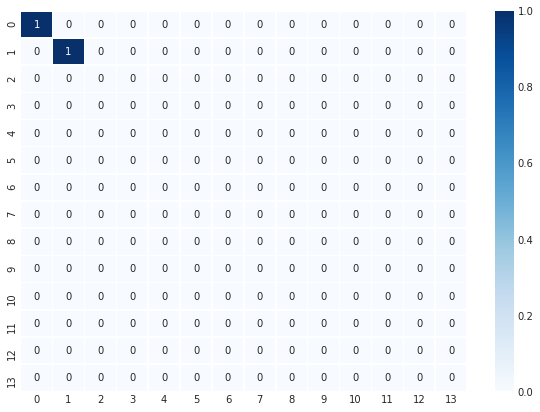

In [93]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

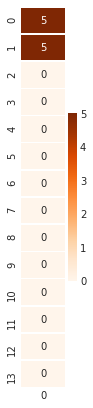

In [94]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

## Testing Results

The above code implements the `initialize_constraints` function to generate a square matrix informed by the *N_steps* and *num_landmarks* inputs.  The results are an Omega matrix which shows the robot's starting position in blue and a Xi vector which shows the certainty of the robot's position as a function of a heatmap.  

---
## SLAM inputs 

In addition to `data`, my slam function will also take in:
* N -   The number of time steps that a robot will be moving and sensing
* num_landmarks - The number of landmarks in the world
* world_size - The size (w/h) of your world
* motion_noise - The noise associated with motion; the update confidence for motion should be `1.0/motion_noise`
* measurement_noise - The noise associated with measurement/sensing; the update weight for measurement should be `1.0/measurement_noise`

#### Updating with motion and measurements

The solution to the constraint matrices (which holds all values for robot poses `P` and landmark locations `L`) is the vector, `mu`, which can be computed at the end of the construction of omega and xi as the inverse of omega times xi: $\mu = \Omega^{-1}\xi$

## Implementing Graph SLAM

In [95]:
## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    # initialize constraint matrix omega, vector xi
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    
    # Iterate through each time step in data to get motion and measurements
    for i in range(len(data)):
        measurements = data[i][0]
        motion = data[i][1]
        
        # add the measurement noise
        #measurements[0] = landmark index
        #measurements[0][1] = x-dist btw robot / landmark
        #measurements[0][2] = y-dist btw robot / landmark
        for measurement in measurements:
            # access the measurement data, store in vars
            indx_landmark = measurement[0]
            x, y = measurement[1], measurement[2]

            # update x by skipping every other y in omega
            # insert 1's at the diagonal
            omega[2 * i, 2 * i] += 1 / measurement_noise
            
            # insert -1's elsewhere in row for landmarks Lx
            omega[2 * i, 2 * N + 2 * indx_landmark] += -1 / measurement_noise
            
            # insert -1's elsewhere in col for landmarks
            omega[2 * N + 2 * indx_landmark, 2 * i] += -1 / measurement_noise
            
            # insert 1's where lx = Lx in row/col
            omega[2 * N + 2 * indx_landmark, 2 * N + 2 * indx_landmark] += 1 / measurement_noise
            
            # in xi every other row add neg distance x measurement
            xi[2 * i, 0] += -x / measurement_noise
            
            # in xi every other row for landmarks add pos x measurement where Lx +1 in omega
            xi[2 * N + 2 * indx_landmark, 0] += x / measurement_noise
            
            # update y by filling-in gaps between x's
            # add 1's to omega matrix diagonal
            omega[2 * i + 1, 2 * i + 1] += 1 / measurement_noise
            
            # subtract 1 from Ly cols
            omega[2 * i + 1, 2 * N + 2 * indx_landmark + 1] += -1 / measurement_noise
            
            # subtract 1 from Ly rows
            omega[2 * N + 2 * indx_landmark + 1, 2 * i + 1] += -1 / measurement_noise
            
            # add 1 to Ly = Ly
            omega[2 * N + 2 * indx_landmark + 1, 2 * N + 2 * indx_landmark + 1] += 1 / measurement_noise
            
            # in xi every other row add neg y measurement
            xi[2 * i + 1, 0] += -y / measurement_noise
            
            # in xi every other row for landmarks add pos y measurement where Ly + 1 in omega
            xi[2 * N + 2 * indx_landmark + 1, 0] += y / measurement_noise
            
        # update constraint matrix/vector to account for all motion and motion noise
        dx = motion[0]
        dy = motion[1]
        
        # add motion noise to omega x w/ each dx robot move
        # add 1 at diagonal
        omega[2 * i, 2 * i] += 1 / motion_noise
        
        # skip robot y, add -1 to robot x in row
        omega[2 * i, 2 * i + 2] += -1 / motion_noise
        
        # skip robot y, add -1 to robot x in col
        omega[2 * i + 2, 2 * i] += -1 / motion_noise
        
        # add 1 where robot x consecutive
        omega[2 * i + 2, 2 * i + 2] += 1 / motion_noise
        
        # substract dx from xi where omega x is neg
        xi[2 * i, 0] += -dx / motion_noise
        
        # add dx to xi where omega x is pos
        xi[2 * i + 2, 0] += dx / motion_noise
        
        # add motion noise to omega y w/ each dy robot move
        # add 1 at diagonal
        omega[2 * i + 1, 2 * i + 1] += 1 / motion_noise
        
        # skip 2 col add neg for consec positions skip x
        omega[2 * i + 1, 2 * i + 3] += -1 / motion_noise
        
        # repeat for row
        omega[2 * i + 3, 2 * i + 1] += -1 / motion_noise
        
        # add 1 where consec row y == col y
        omega[2 * i + 3, 2 * i + 3] += 1 / motion_noise
        
        # substract dy from xi where omega y is neg for current step
        xi[2 * i + 1, 0] += -dy / motion_noise
        
        # add dy to xi where omega y is pos for current motion
        xi[2 * i + 3, 0] += dy / motion_noise                                             
    
    ## After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    print('Shape of Omega: ', omega.shape)
    print('Shape of Xi: ', xi.shape, '\n')
    print('Omega is: \n', omega, '\n')
    print('Omega inverse is: \n', (np.linalg.inv(omega)))
    # try dot product instead of straight mult syntax
    mu = np.dot(np.linalg.inv(omega), xi)
    
    return mu # return `mu`

## Helper functions

To check that my implementation of SLAM works for various inputs, Udacity provided two helper functions that will help display the estimated pose and landmark locations that my function has produced. First, given a result `mu` and number of time steps, `N`, it defines a function that extracts the poses and landmarks locations and returns those as their own, separate lists. 

Then, it defines a function that nicely print out these lists; both are called in the next step.

In [96]:
# a helper function that creates a list of poses and of landmarks for ease of printing
# this only works for the suggested constraint architecture of interlaced x,y poses
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


In [97]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


## Run SLAM

Once I've completed my implementation of `slam`, I check what `mu` it returns for different world sizes and different landmarks!

### What to Expect

The `data` that is generated is random, but I did specify the number, `N`, or time steps that the robot was expected to move and the `num_landmarks` in the world, which my implementation of `slam` should see and estimate a position for. The robot will also start with an estimated pose in the very center of the square world, whose size is defined by `world_size`.

With these values in mind, I expect to see a result that displays two lists:
1. **Estimated poses**, a list of (x, y) pairs that is exactly `N` in length since this is how many motions the robot has taken. The very first pose should be the center of the world, i.e. `[50.000, 50.000]` for a world that is 100.0 in square size.
2. **Estimated landmarks**, a list of landmark positions (x, y) that is exactly `num_landmarks` in length. 

#### Landmark Locations

If you refer back to the printout of *exact* landmark locations when this data was created, you should see values that are very similar to those coordinates, but not quite (since `slam` must account for noise in motion and measurement).

In [98]:
# call my implementation of slam, passing in the necessary parameters
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)

Shape of Omega:  (50, 50)
Shape of Xi:  (50, 1) 

Omega is: 
 [[ 4.   0.  -0.5 ...,  0.  -0.5  0. ]
 [ 0.   4.   0.  ..., -0.5  0.  -0.5]
 [-0.5  0.   3.5 ...,  0.  -0.5  0. ]
 ..., 
 [ 0.  -0.5  0.  ...,  7.5  0.   0. ]
 [-0.5  0.  -0.5 ...,  0.   3.5  0. ]
 [ 0.  -0.5  0.  ...,  0.   0.   3.5]] 

Omega inverse is: 
 [[ 1.          0.          1.         ...,  0.          1.          0.        ]
 [ 0.          1.          0.         ...,  1.          0.          1.        ]
 [ 1.          0.          1.54536148 ...,  0.          1.29978142  0.        ]
 ..., 
 [ 0.          1.          0.         ...,  1.46178325  0.          1.27477885]
 [ 1.          0.          1.29978142 ...,  0.          1.59130454  0.        ]
 [ 0.          1.          0.         ...,  1.27477885  0.          1.59130454]]


Estimated Poses:
[50.000, 50.000]
[37.260, 65.586]
[23.597, 79.798]
[8.550, 94.597]
[8.322, 75.434]
[8.594, 53.780]
[9.903, 34.430]
[10.401, 15.457]
[31.252, 14.452]
[50.750, 13.873]
[70.714

## Visualize the constructed world

Finally, using the `display_world` code from the `helpers.py` file, I can actually visualize what I have coded with `slam`: the final position of the robot and the positon of landmarks, created from only motion and measurement data.

**Note that these should be very similar to the printed *true* landmark locations and final pose from the call to `make_data` early in this notebook.**

Last pose:  (44.726524848267374, 80.08161270792365)


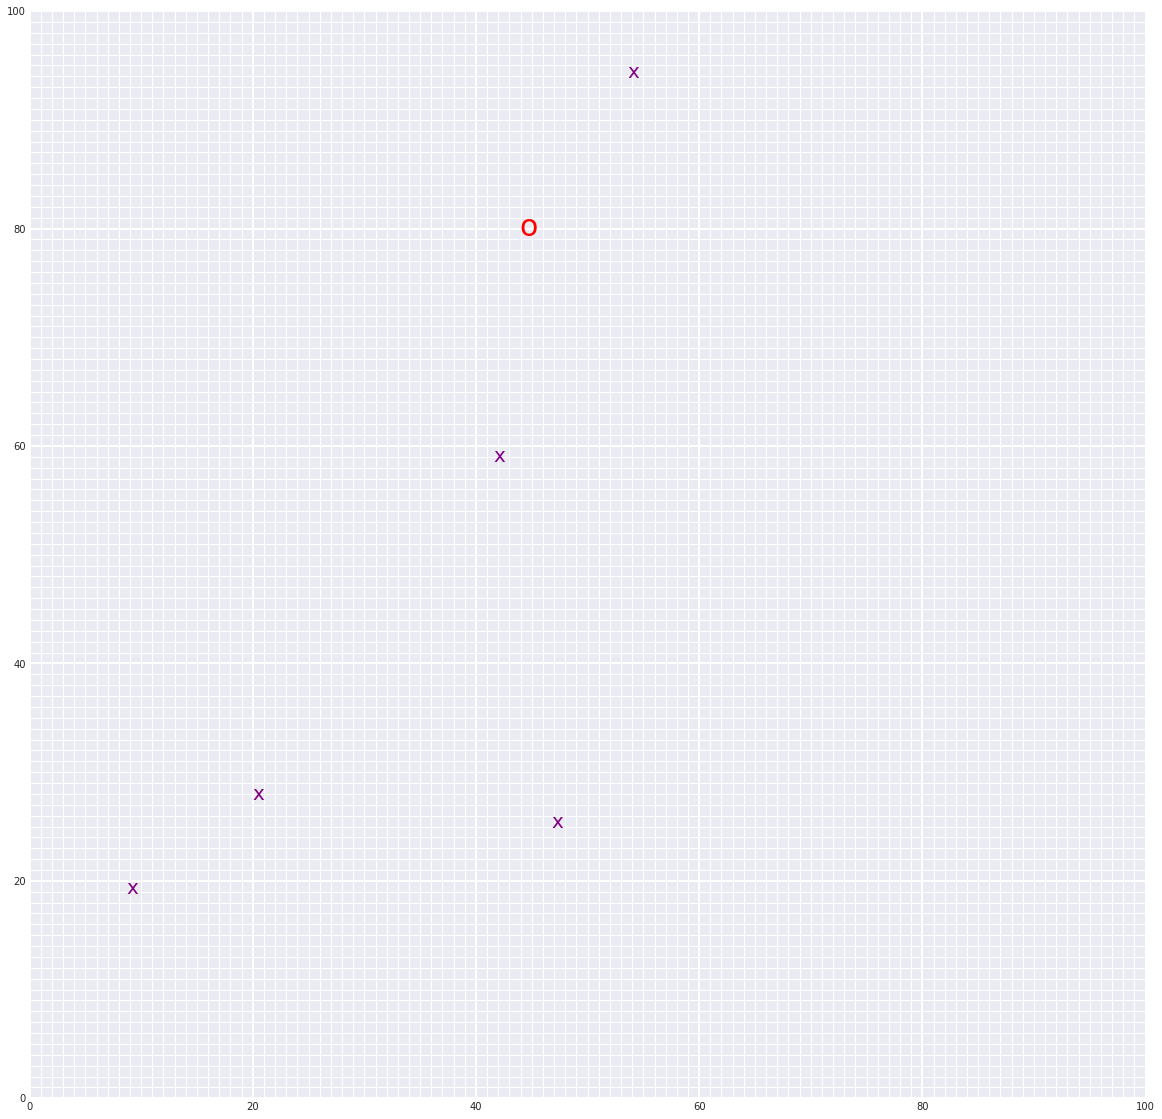

In [99]:
# import the helper function
from helpers import display_world

# Display the final world!

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)
    

### Test when N = 20 ###
Actual robot final pose when N = 20: (45.97480 79.67049) <br>
Estimtaed robot final pose when N = 20: (44.727, 80.082) <br>
Visualized robot final pose when N=20: (44.726524848267374, 80.08161270792365)


### Question: How far away is your final pose (as estimated by `slam`) compared to the *true* final pose? Why do you think these poses are different?

**My Answer**: To help me better understand a solution to this project I referenced several published papers on GraphSLAM that I found online.  The most helpful to me was a paper written by Sebastian Thrun and Michael Montemerlo in the June 2006 volume of 'The International Journal of Robotics Research.'  On page 407 of the journal, they write:

<em>'...since the inverse of Omega is multiplied with a vector, the result can be computed with optimization techniques such as conjugate gradient descent, without explicitly computing the full inverse matrix.  Since most worlds possess cycles, this is the case of interest.'</em>

When Thrun and Montemerlo write about cycles, they refer to a challenge that emerges when a robot records a landmark it has already seen much earlier in time.  How can the robot know it has not found a new landmark but has revisted an old one?  The solution grows in complexity with the size of the world and its number of landmarks.  

Therefore, I imagine that with increasingly more movement and measurement data within a finite map (determined if not by geography then by either the robot's battery life or memory bank) the quality of the robot's mapping will plateau.  Once the robot begins repeating its behavior, re-recording data, the cost of calculating its mu vector increases while the value of its result diminishes.  

In regard to lower/higher noise parameters, I believe higher noise parameters would muddy the results calculated by Slam.  Why?  In the version of Slam I implemented, I divided each addition to Omega and Xi by a value of noise.  The higher the noise value the lower the value of my addition to the matrices.  As we learned in our lecture series, the values we add to the constraint matrix represent weights.  Thrun and Montemarlo write on page 406 of their paper:

<em>'The magnitude of the values added between the rows and columns connecting xt-1 and xt corresponds to the stiffness of the constraint...the less noisy the sensor, the larger the value added to Omega and Xi.'</em>

Therefore, more noise in our measurements would lower the value of our weights in our constraint matrix, which in turn would muddy the relative strength of some constraints over others.  Less noise in measurement and motion is best.

### Test N = 200 when World_Size = 100, Num_Landmarks = 5###


In [100]:
num_landmarks      = 5        # number of landmarks
N                  = 200       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data_bigN = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[24, 77], [67, 76], [99, 71], [61, 13], [16, 18]]
Robot: [x=18.44270 y=4.25674]


In [101]:
mu_bigN = slam(data_bigN, 200, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_bigN, N)
print_all(poses, landmarks)

Shape of Omega:  (410, 410)
Shape of Xi:  (410, 1) 

Omega is: 
 [[  4.    0.   -0.5 ...,   0.   -0.5   0. ]
 [  0.    4.    0.  ...,  -0.5   0.   -0.5]
 [ -0.5   0.    3.  ...,   0.   -0.5   0. ]
 ..., 
 [  0.   -0.5   0.  ...,  63.    0.    0. ]
 [ -0.5   0.   -0.5 ...,   0.   51.    0. ]
 [  0.   -0.5   0.  ...,   0.    0.   51. ]] 

Omega inverse is: 
 [[ 1.          0.          1.         ...,  0.          1.          0.        ]
 [ 0.          1.          0.         ...,  1.          0.          1.        ]
 [ 1.          0.          1.58342978 ...,  0.          1.28528531  0.        ]
 ..., 
 [ 0.          1.          0.         ...,  1.35930705  0.          1.34182312]
 [ 1.          0.          1.28528531 ...,  0.          1.36287227  0.        ]
 [ 0.          1.          0.         ...,  1.34182312  0.          1.36287227]]


Estimated Poses:
[50.000, 50.000]
[30.823, 45.374]
[11.994, 39.949]
[32.018, 43.252]
[51.981, 48.598]
[73.184, 51.536]
[93.563, 54.964]
[85.802, 37.745

## Visualize Constructed World

Last pose:  (18.93016307736889, 5.787428617260275)


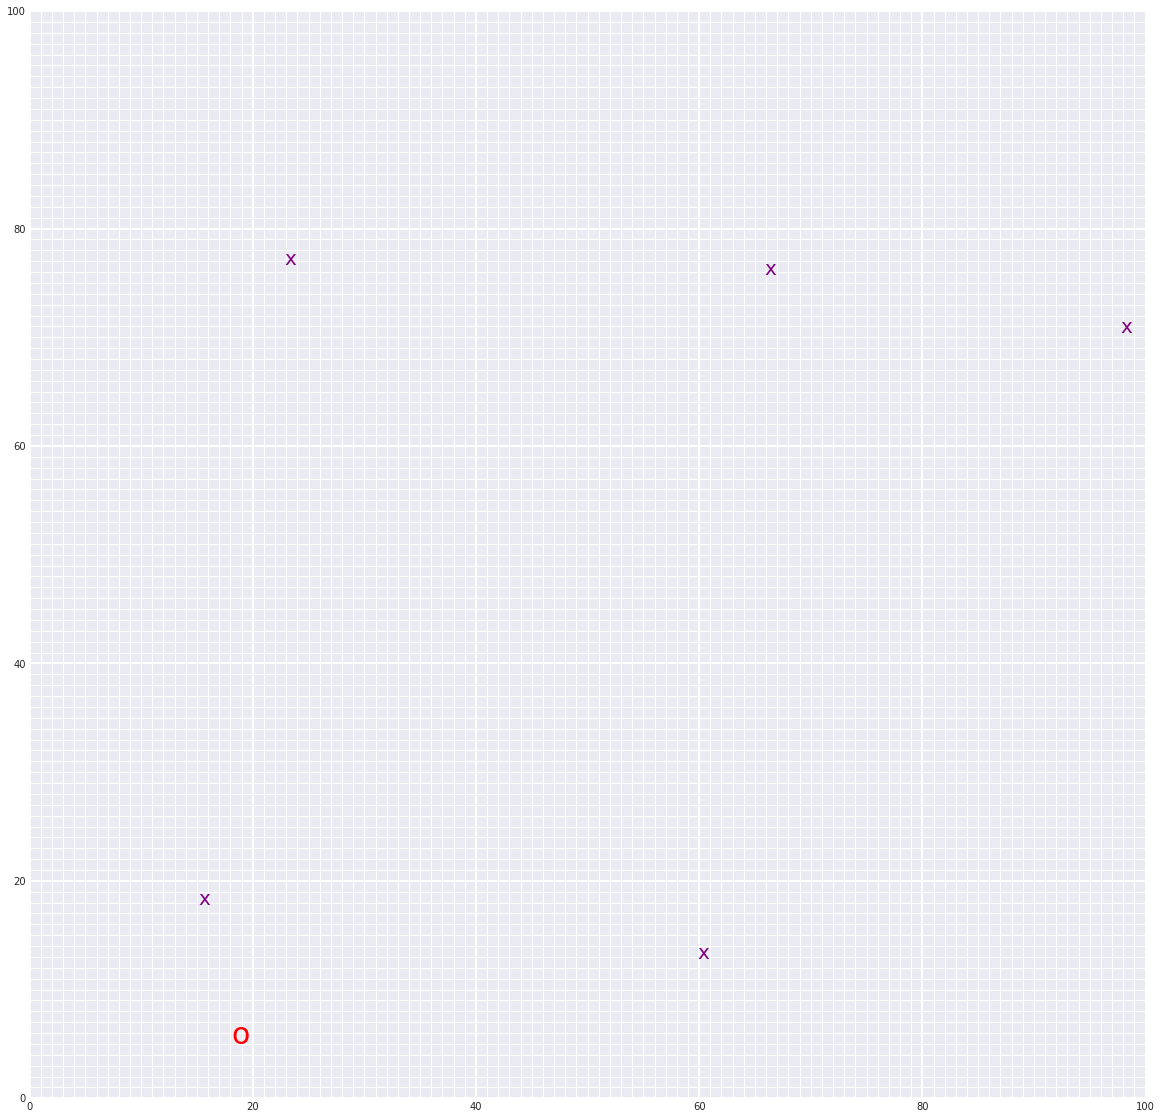

In [102]:
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

Actual robot pose when x = 200: Robot: (18.44270, 4.25674) <br>
Estimated robot pose when x = 200: (18.930, 5.787) <br>
Visualized robot pose when x = 200:(18.93016307736889, 5.787428617260275)

### Test when N = 2000, World_Size = 100, Num_Landmarks = 5 ###

In [103]:
num_landmarks      = 5        # number of landmarks
N                  = 2000       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data_bigN = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[32, 96], [34, 84], [57, 25], [64, 88], [20, 18]]
Robot: [x=19.00193 y=87.72109]


In [104]:
mu_bigN = slam(data_bigN, 2000, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_bigN, N)
print_all(poses, landmarks)

Shape of Omega:  (4010, 4010)
Shape of Xi:  (4010, 1) 

Omega is: 
 [[  4.00000000e+00   0.00000000e+00  -5.00000000e-01 ...,   0.00000000e+00
   -5.00000000e-01   0.00000000e+00]
 [  0.00000000e+00   4.00000000e+00   0.00000000e+00 ...,  -5.00000000e-01
    0.00000000e+00  -5.00000000e-01]
 [ -5.00000000e-01   0.00000000e+00   2.00000000e+00 ...,   0.00000000e+00
   -5.00000000e-01   0.00000000e+00]
 ..., 
 [  0.00000000e+00  -5.00000000e-01   0.00000000e+00 ...,   5.42500000e+02
    0.00000000e+00   0.00000000e+00]
 [ -5.00000000e-01   0.00000000e+00  -5.00000000e-01 ...,   0.00000000e+00
    4.72000000e+02   0.00000000e+00]
 [  0.00000000e+00  -5.00000000e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   4.72000000e+02]] 

Omega inverse is: 
 [[ 1.          0.          1.         ...,  0.          1.          0.        ]
 [ 0.          1.          0.         ...,  1.          0.          1.        ]
 [ 1.          0.          1.72327403 ...,  0.          1.25606624  0.

[25.453, 85.182]
[42.536, 74.888]
[58.665, 61.723]
[75.711, 51.950]
[91.264, 40.927]
[85.638, 21.194]
[80.362, 1.452]
[64.347, 12.749]
[49.640, 24.589]
[35.385, 36.471]
[20.454, 48.804]
[3.192, 61.427]
[13.195, 45.429]
[24.754, 27.704]
[34.621, 10.820]
[17.710, 3.135]
[4.934, 19.494]
[16.171, 4.288]
[34.326, 10.126]
[53.420, 15.544]
[73.126, 20.165]
[92.175, 25.413]
[73.299, 31.476]
[56.162, 39.106]
[37.748, 44.302]
[18.048, 52.603]
[0.989, 60.239]
[2.654, 41.219]
[3.823, 21.786]
[5.227, 1.364]
[0.811, 21.417]
[21.301, 16.987]
[41.582, 12.000]
[63.839, 7.625]
[84.041, 4.263]
[71.833, 19.937]
[60.744, 34.651]
[48.200, 50.702]
[36.307, 67.730]
[25.545, 83.334]
[38.056, 66.236]
[51.051, 51.114]
[63.592, 36.749]
[75.050, 21.972]
[86.134, 5.440]
[65.291, 4.652]
[43.282, 3.821]
[21.761, 3.668]
[24.020, 24.801]
[26.832, 45.315]
[29.837, 64.150]
[34.326, 83.729]
[24.610, 67.773]
[13.740, 50.115]
[2.843, 32.984]
[17.169, 19.355]
[31.847, 4.655]
[20.893, 21.074]
[10.533, 38.212]
[2.372, 54.718]


## Visualize Constructed World

Last pose:  (19.66989773073692, 89.36577996563938)


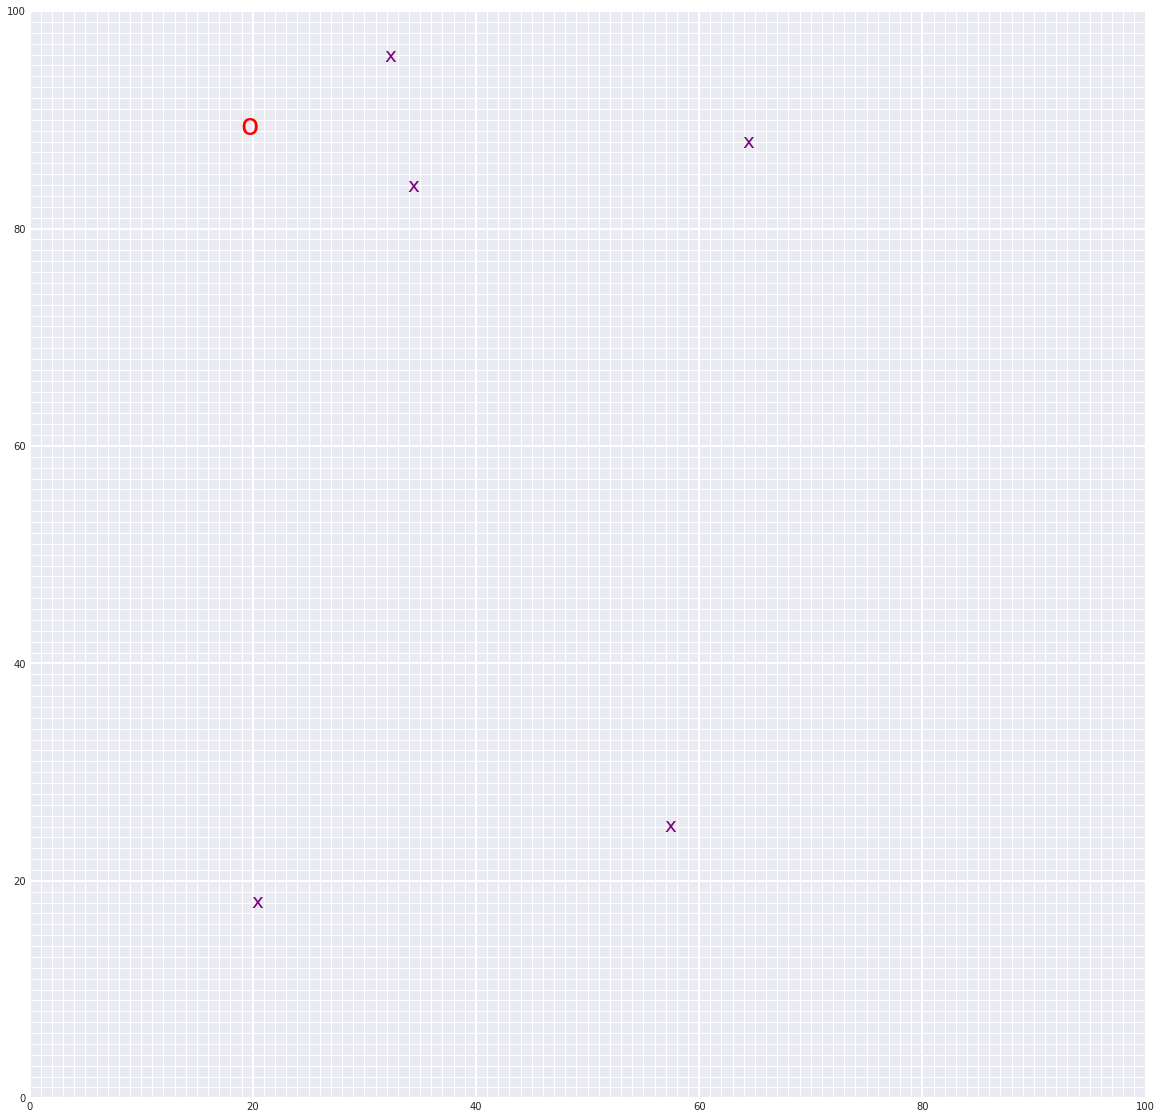

In [105]:
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

Actual robot pose when x = 2000: Robot: (19.00193, 87.72109) <br>
Estimated robot pose when x = 2000: (19.670, 89.366) <br>
Visualized robot pose when x = 2000: (19.66989773073692, 89.36577996563938)

<strong>Conclusion: </strong>As 'N', the number of steps taken by the robot, increases while the size of the world and number of landmarks remains the same, the robot's estimated measurements of its locations becomes less accurate.

## Further Data Testing

To confirm that my slam code works, I have run it on some test data and cases. A few such cases have been provided by Udacity, in the cells below.  My output should be **close-to or exactly** identical to the given results. If there are minor discrepancies it could be a matter of floating point accuracy or in the calculation of the inverse matrix.

In [107]:
# Here is the data and estimated outputs for test case 1

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]

##  Test Case 1
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [37.858, 33.921]
#     [25.905, 18.268]
#     [13.524, 2.224]
#     [27.912, 16.886]
#     [42.250, 30.994]
#     [55.992, 44.886]
#     [70.749, 59.867]
#     [85.371, 75.230]
#     [73.831, 92.354]
#     [53.406, 96.465]
#     [34.370, 100.134]
#     [48.346, 83.952]
#     [60.494, 68.338]
#     [73.648, 53.082]
#     [86.733, 38.197]
#     [79.983, 20.324]
#     [72.515, 2.837]
#     [54.993, 13.221]
#     [37.164, 22.283]


# Estimated Landmarks:
#     [82.679, 13.435]
#     [70.417, 74.203]
#     [36.688, 61.431]
#     [18.705, 66.136]
#     [20.437, 16.983]

### Uncomment the following three lines for test case 1 and compare the output to the values above ###
'''
Calculated Results:

Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]

'''
mu_1 = slam_2(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)

Shape of Omega:  (50, 50)
Shape of Xi:  (50, 1) 

Omega is: 
 [[ 3.   0.  -0.5 ...,  0.   0.   0. ]
 [ 0.   3.   0.  ..., -0.5  0.   0. ]
 [-0.5  0.   2.  ...,  0.  -0.5  0. ]
 ..., 
 [ 0.  -0.5  0.  ...,  1.5  0.   0. ]
 [ 0.   0.  -0.5 ...,  0.   3.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   3. ]] 

Omega inverse is: 
 [[ 1.          0.          1.         ...,  0.          1.          0.        ]
 [ 0.          1.          0.         ...,  1.          0.          1.        ]
 [ 1.          0.          2.00169667 ...,  0.          1.7415595   0.        ]
 ..., 
 [ 0.          1.          0.         ...,  2.03165803  0.          1.29796362]
 [ 1.          0.          1.7415595  ...,  0.          2.34859817  0.        ]
 [ 0.          1.          0.         ...,  1.29796362  0.          2.34859817]]


Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.

In [17]:
# Here is the data and estimated outputs for test case 2

test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 


##  Test Case 2
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [69.035, 45.061]
#     [87.655, 38.971]
#     [76.084, 55.541]
#     [64.283, 71.684]
#     [52.396, 87.887]
#     [44.674, 68.948]
#     [37.532, 49.680]
#     [31.392, 30.893]
#     [24.796, 12.012]
#     [33.641, 26.440]
#     [43.858, 43.560]
#     [54.735, 60.659]
#     [65.884, 77.791]
#     [77.413, 94.554]
#     [96.740, 98.020]
#     [76.149, 99.586]
#     [70.211, 80.580]
#     [64.130, 61.270]
#     [58.183, 42.175]


# Estimated Landmarks:
#     [76.777, 42.415]
#     [85.109, 76.850]
#     [13.687, 95.386]
#     [59.488, 39.149]
#     [69.283, 93.654]


### Uncomment the following three lines for test case 2 and compare to the values above ###
'''
Calculated Results:

Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]

'''

mu_2 = slam_2(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)


Shape of Omega:  (50, 50)
Shape of Xi:  (50, 1) 

Omega is: 
 [[ 2.5  0.  -0.5 ...,  0.   0.   0. ]
 [ 0.   2.5  0.  ..., -0.5  0.   0. ]
 [-0.5  0.   2.5 ...,  0.   0.   0. ]
 ..., 
 [ 0.  -0.5  0.  ...,  6.5  0.   0. ]
 [ 0.   0.   0.  ...,  0.   5.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   5. ]] 

Omega inverse is: 
 [[ 1.          0.          1.         ...,  0.          1.          0.        ]
 [ 0.          1.          0.         ...,  1.          0.          1.        ]
 [ 1.          0.          1.87661399 ...,  0.          1.59221429  0.        ]
 ..., 
 [ 0.          1.          0.         ...,  1.80901909  0.          1.70118715]
 [ 1.          0.          1.59221429 ...,  0.          2.06389728  0.        ]
 [ 0.          1.          0.         ...,  1.70118715  0.          2.06389728]]


Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34

## Tests Passed!

The two tests cases above each used a unique set of data to generate a world_map, navigate the robot, calculate the distance to landmarks, and predict the robot's path.  Because the tests passed, resulting in output from my slam function that matches the expected results, I conclude I have successfully completed the Graph SLAM implementation project for the Udacity-Nvidia Nanodegree in Computer Vision.